=== Первые 5 строк датасета ===
   player_id                                player_url  fifa_version  \
0     252371    /player/252371/jude-bellingham/260004/            26   
1     239053  /player/239053/federico-valverde/260004/            26   
2     212622     /player/212622/joshua-kimmich/260004/            26   
3     235212      /player/235212/achraf-hakimi/260004/            26   
4     224232     /player/224232/nicolo-barella/260004/            26   

   fifa_update fifa_update_date     short_name  \
0            4       2025-09-19  J. Bellingham   
1            4       2025-09-19    F. Valverde   
2            4       2025-09-19     J. Kimmich   
3            4       2025-09-19      A. Hakimi   
4            4       2025-09-19     N. Barella   

                            long_name player_positions  overall  potential  \
0      Jude Victor William Bellingham          CAM, CM       90         94   
1  Federico Santiago Valverde Dipetta      CM, CDM, RB       89         90   


C:\Users\Zavar\Documents\GitHub\Predicting-a-player-based-on-his-fc26-stats\venv\lib\site-packages\xgboost\training.py:183: UserWarning: [01:09:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.7340396631350177
              precision    recall  f1-score   support

         CAM       0.67      0.63      0.65       227
          CB       0.92      0.95      0.93       665
         CDM       0.72      0.67      0.69       287
          CM       0.73      0.85      0.78       443
          GK       1.00      1.00      1.00       412
          LB       0.54      0.48      0.51       273
          LM       0.36      0.42      0.39       213
          LW       0.32      0.11      0.17        79
          RB       0.53      0.53      0.53       285
          RM       0.36      0.33      0.34       203
          RW       0.28      0.14      0.18        87
          ST       0.88      0.96      0.92       507

    accuracy                           0.73      3681
   macro avg       0.61      0.59      0.59      3681
weighted avg       0.72      0.73      0.72      3681



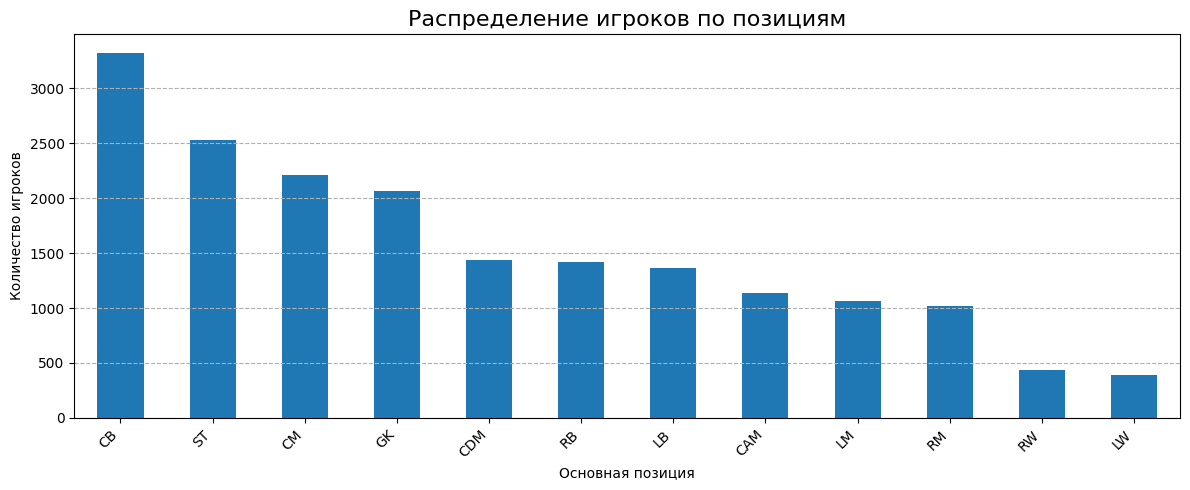

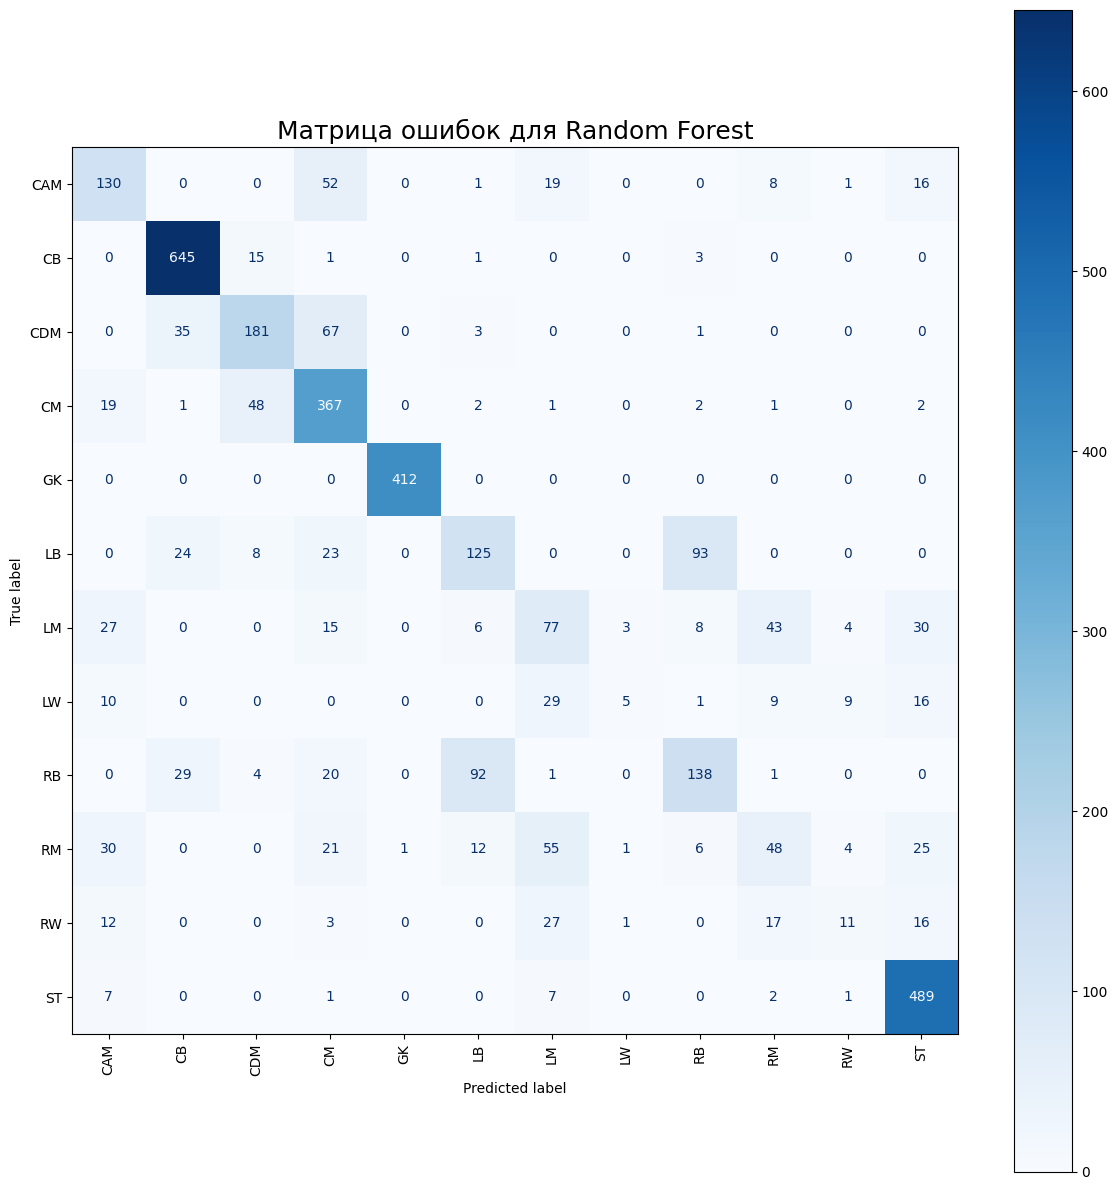

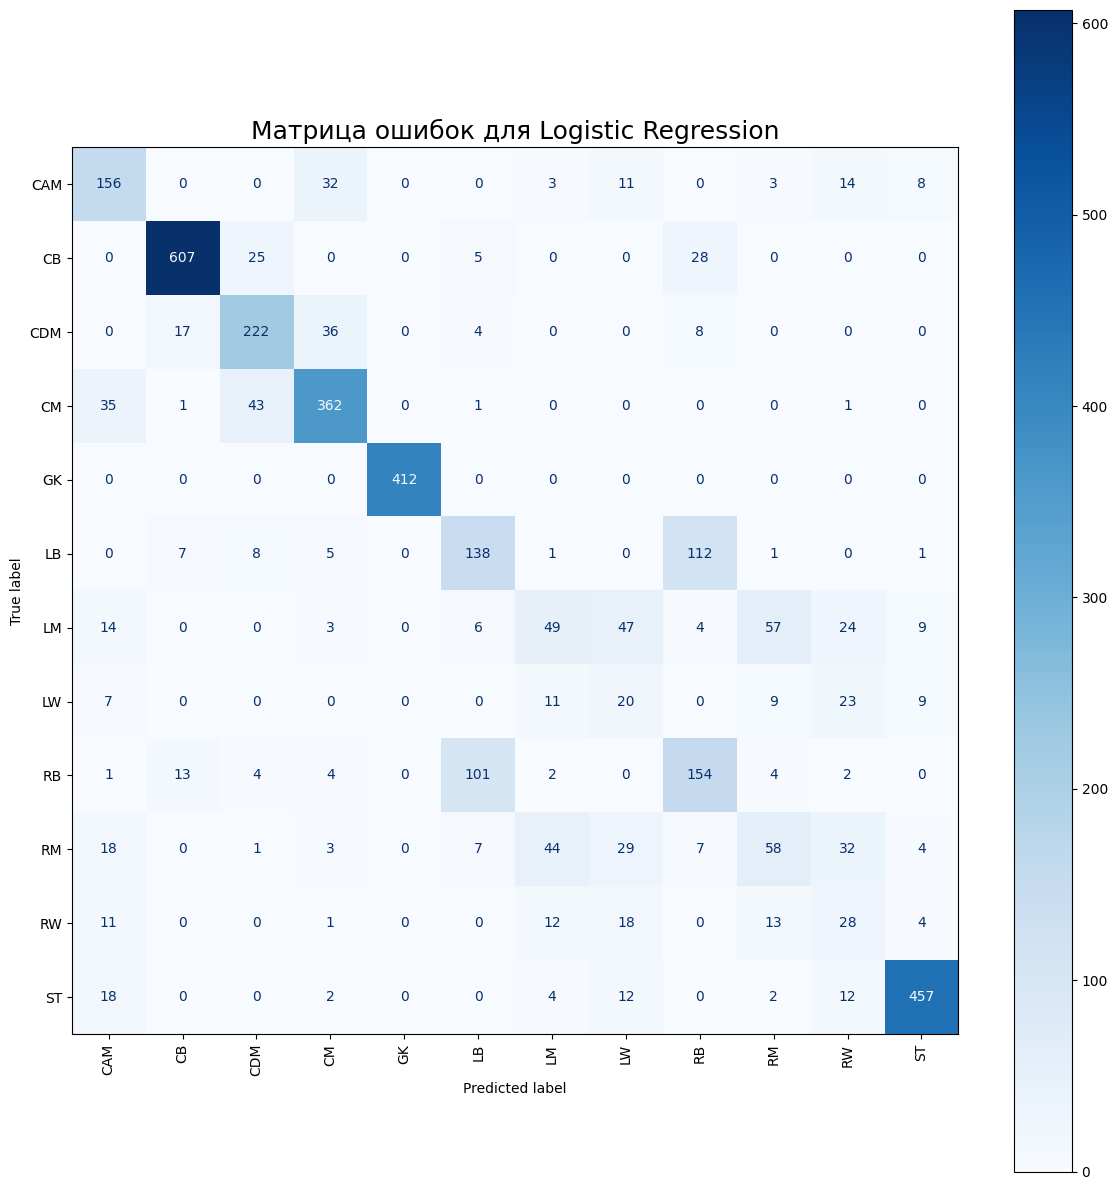

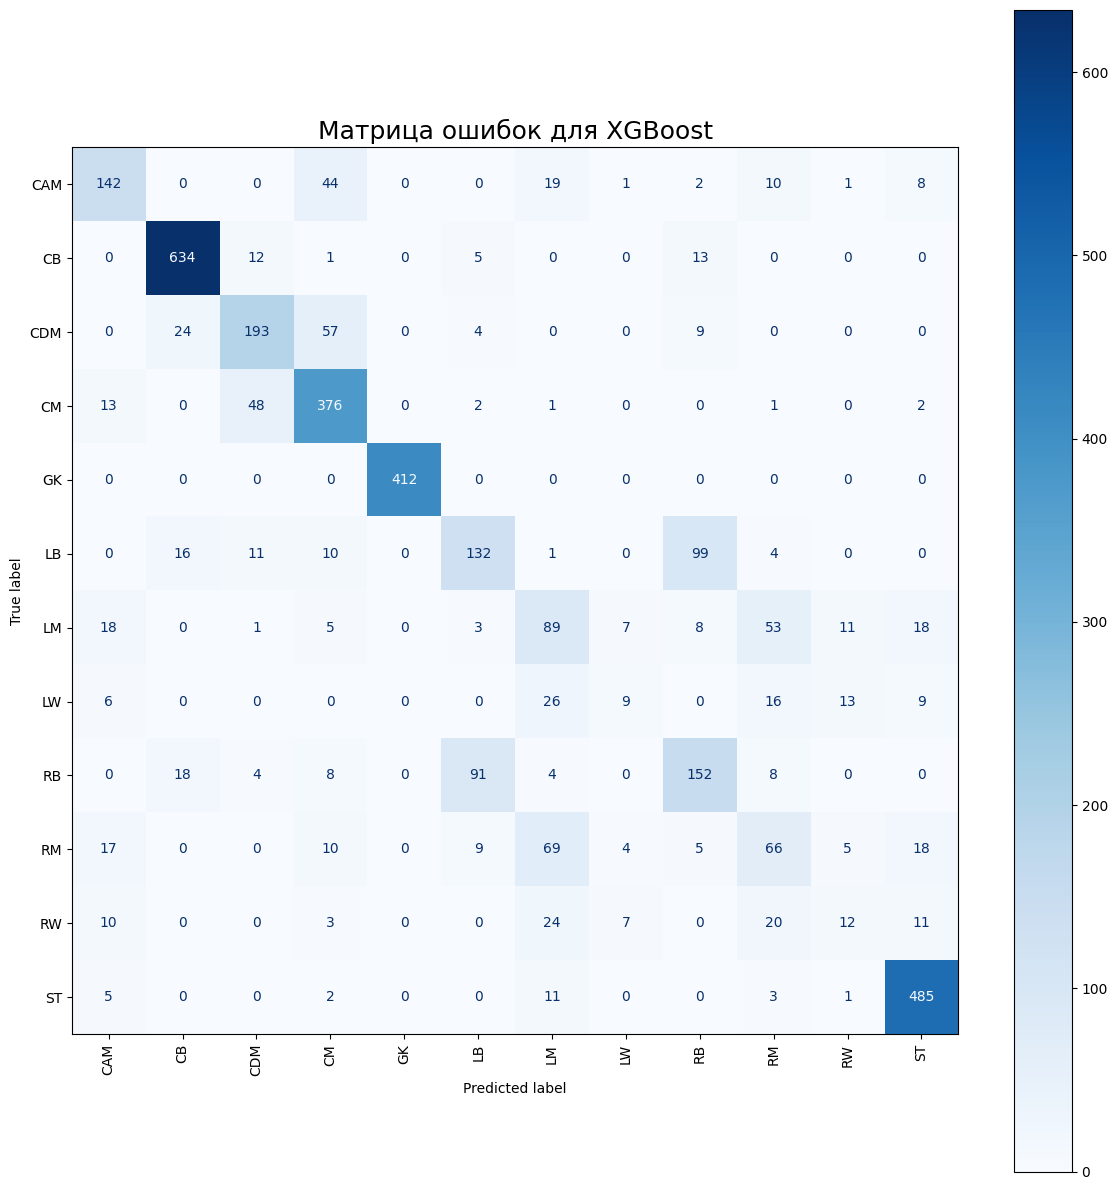

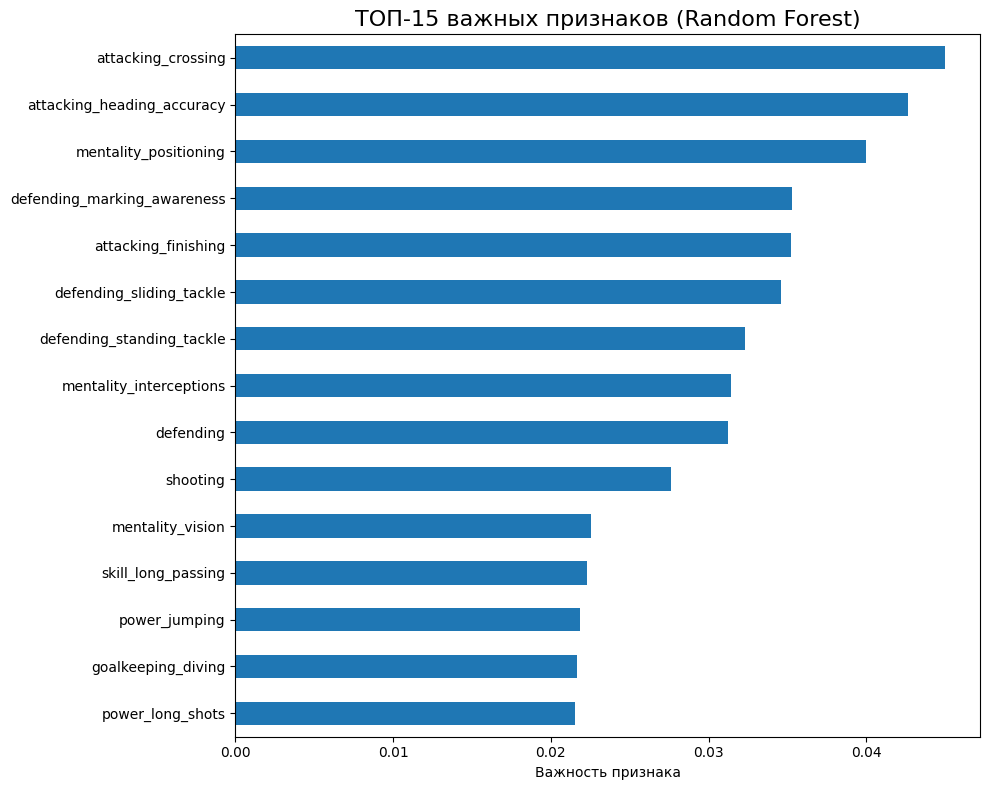


=== Сводка точности моделей ===
                 Model  Accuracy
2              XGBoost  0.734040
1  Logistic Regression  0.723445
0        Random Forest  0.713936


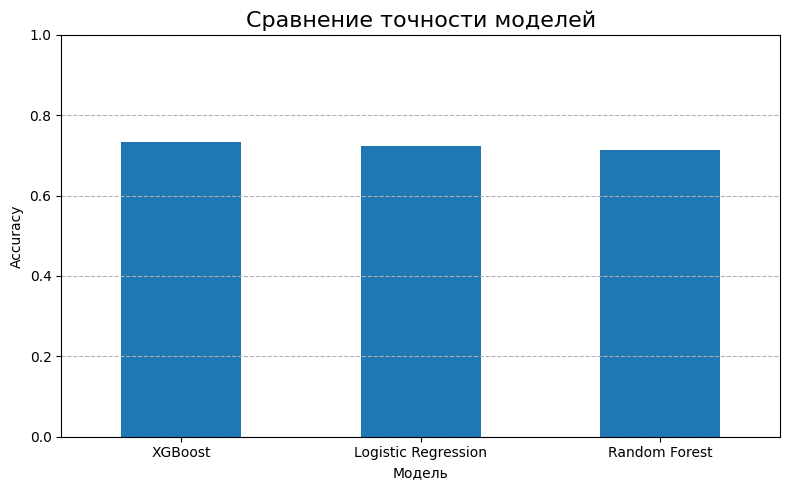


               ИТОГОВЫЙ ТЕКСТ И ВЫВОДЫ
## 1. Обзор проекта
Целью данного проекта была **классификация основной игровой позиции** футболиста (из игры FC26) на основе его статистических числовых характеристик.
В качестве целевой переменной была выбрана первая позиция из списка 'player_positions', что привело к сильному **дисбалансу классов** (позиции ST, CB, CM, GK доминируют).

## 2. Сравнение эффективности моделей
Были протестированы три модели: **Random Forest**, **Logistic Regression** (с балансировкой классов) и **XGBoost**.
              Model  Accuracy
            XGBoost  0.734040
Logistic Regression  0.723445
      Random Forest  0.713936
Наилучший результат по метрике **Accuracy** (доля правильных ответов) показала модель **XGBoost** с точностью $\approx 0.7340$.

## 3. Анализ Матриц ошибок
Анализ матриц ошибок показывает, что:
- **Random Forest** и **XGBoost** демонстрируют высокую способность к правильной классификации, особенно для доминирующих позиций, таких как **CB (Цент

In [ ]:
# === Импорты ===
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np 



path = r"C:\Users\Zavar\Documents\GitHub\Predicting-a-player-based-on-his-fc26-stats\archive"
file = "FC26_20250921.csv"
try:
    df = pd.read_csv(os.path.join(path, file), low_memory=False)
except FileNotFoundError:
    print(f"Ошибка: Файл не найден по пути {os.path.join(path, file)}")
    exit()

# === Первичный анализ ===
print("=== Первые 5 строк датасета ===")
print(df.head())
print("\n=== Информация о датасете ===")
df.info()
print("\nПропуски в датасете (общее количество):\n", df.isnull().sum().sum())

# === Создание основной позиции ===
df["main_position"] = df["player_positions"].str.split(",").str[0]
print("\nКоличество игроков по основной позиции:\n", df["main_position"].value_counts())


X = df.select_dtypes(include=["int64", "float64"]).drop(
    columns=["player_id", "fifa_version", "fifa_update", "work_rate"], errors="ignore"
)
y = df["main_position"]

# === Импутация пропусков ===
imputer = SimpleImputer(strategy="mean")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# === Кодирование целевой переменной ===
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_ # Сохраняем названия классов для матриц ошибок

# === Разделение на train/test ===
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded # Добавим stratify
)

# === Масштабирование для Logistic Regression ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# ----------------------------------------------------------------------
# ## Обучение моделей
# ----------------------------------------------------------------------

# === Random Forest ===
print("\n=== Random Forest ===")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", rf_accuracy)
print(classification_report(y_test, y_pred_rf, target_names=class_names))

# === Logistic Regression ===
print("\n=== Logistic Regression ===")
lr_model = LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42)
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
lr_accuracy = accuracy_score(y_test, y_pred_lr)
print("Accuracy:", lr_accuracy)
print(classification_report(y_test, y_pred_lr, target_names=class_names))

# === XGBoost ===
print("\n=== XGBoost ===")
xgb_model = XGBClassifier(eval_metric="mlogloss", use_label_encoder=False, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
print("Accuracy:", xgb_accuracy)
print(classification_report(y_test, y_pred_xgb, target_names=class_names))


# ----------------------------------------------------------------------
# ## Визуализация результатов
# ----------------------------------------------------------------------

# === Визуализация распределения игроков по позициям ===
plt.figure(figsize=(12, 5))
df["main_position"].value_counts().plot(kind="bar")
plt.title("Распределение игроков по позициям", fontsize=16)
plt.ylabel("Количество игроков")
plt.xlabel("Основная позиция")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

# ---
# ## Матрицы ошибок
# ---

def plot_confusion_matrix(y_true, y_pred, classes, title):
    """Строит и отображает матрицу ошибок."""
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    fig, ax = plt.subplots(figsize=(12, 12))
    disp.plot(xticks_rotation=90, ax=ax, cmap=plt.cm.Blues, values_format='d')
    plt.title(title, fontsize=18)
    plt.tight_layout()
    plt.show()

# === Матрица ошибок для Random Forest ===
plot_confusion_matrix(y_test, y_pred_rf, class_names, "Матрица ошибок для Random Forest")

# === Матрица ошибок для Logistic Regression ===
plot_confusion_matrix(y_test, y_pred_lr, class_names, "Матрица ошибок для Logistic Regression")

# === Матрица ошибок для XGBoost ===
plot_confusion_matrix(y_test, y_pred_xgb, class_names, "Матрица ошибок для XGBoost")

# ---
# ## Важность признаков (Random Forest)
# ---

importances = rf_model.feature_importances_
feat_importances = pd.Series(importances, index=X.columns)

plt.figure(figsize=(10, 8))
feat_importances.nlargest(15).sort_values().plot(kind="barh")
plt.title("ТОП-15 важных признаков (Random Forest)", fontsize=16)
plt.xlabel("Важность признака")
plt.tight_layout()
plt.show()

# ---
# ## Сравнение моделей
# ---

results_df = pd.DataFrame({
    "Model": ["Random Forest", "Logistic Regression", "XGBoost"],
    "Accuracy": [rf_accuracy, lr_accuracy, xgb_accuracy]
})
print("\n=== Сводка точности моделей ===")
print(results_df.sort_values(by="Accuracy", ascending=False))

plt.figure(figsize=(8, 5))
results_df.sort_values(by="Accuracy", ascending=False).plot(x="Model", y="Accuracy", kind="bar", legend=False, ax=plt.gca())
plt.title("Сравнение точности моделей", fontsize=16)
plt.ylabel("Accuracy")
plt.xlabel("Модель")
plt.ylim(0.0, 1.0)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# ## Итоговый текст с выводами
# ----------------------------------------------------------------------

print("\n" + "="*50)
print("               ИТОГОВЫЙ ТЕКСТ И ВЫВОДЫ")
print("="*50)

# 1. Цель проекта
print("## 1. Обзор проекта")
print("Целью данного проекта была **классификация основной игровой позиции** футболиста (из игры FC26) на основе его статистических числовых характеристик.")
print("В качестве целевой переменной была выбрана первая позиция из списка 'player_positions', что привело к сильному **дисбалансу классов** (позиции ST, CB, CM, GK доминируют).")

print("\n## 2. Сравнение эффективности моделей")
print(f"Были протестированы три модели: **Random Forest**, **Logistic Regression** (с балансировкой классов) и **XGBoost**.")
print(results_df.sort_values(by="Accuracy", ascending=False).to_string(index=False))
print(f"Наилучший результат по метрике **Accuracy** (доля правильных ответов) показала модель **{results_df.iloc[results_df['Accuracy'].argmax()]['Model']}** с точностью $\\approx {results_df['Accuracy'].max():.4f}$.")

print("\n## 3. Анализ Матриц ошибок")
print("Анализ матриц ошибок показывает, что:")
print("- **Random Forest** и **XGBoost** демонстрируют высокую способность к правильной классификации, особенно для доминирующих позиций, таких как **CB (Центральный защитник)**, **ST (Нападающий)** и **GK (Вратарь)**, где показатели верного предсказания (диагональные значения) наиболее высоки.")
print("- Основные трудности возникают при различении смежных позиций, например, между **LW/RW (Вингер)** и **LF/RF (Левый/Правый Форвард)**, или между различными типами полузащитников (**CM, CAM, CDM**). Это логично, поскольку характеристики этих игроков часто пересекаются.")
print("- Модель **Logistic Regression**, несмотря на использование 'class_weight=\"balanced\"', показала значительно худшую общую точность, хотя её целью было улучшение предсказаний для минорных классов. Однако, её общая производительность ниже, чем у ансамблевых методов.")

print("\n## 4. Важность признаков (Random Forest)")
print("Из анализа важности признаков, наиболее значимыми для определения позиции игрока являются:")
print(f"- **{feat_importances.nlargest(3).index[0]}**")
print(f"- **{feat_importances.nlargest(3).index[1]}**")
print(f"- **{feat_importances.nlargest(3).index[2]}**")
print("Это подтверждает интуитивные ожидания: для вратаря важны вратарские навыки, а для полевых игроков — ключевые атрибуты, связанные с их ролью (например, 'реакция' и 'позиционирование').")

